# Highlight Cells with Diverse Cycling Rates on the Segmentation Masks: 

Let's contrast the differences in the cell cycling rate & colony expansion capacity in the individual clones.

Here, I picked for you: 
+ a **slow** dividing cell (tree ID #14 highlighted in "darkorange")
+ a **medium** dividing cell (tree ID #36 highlighted in "dodgerblue")
+ a **fast** dividing cell (tree ID #33 highlighted in "limegreen")


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import h5py
import sys
import datetime

from skimage import io
from skimage.segmentation import flood_fill
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from Tree_DataIO import Extract_Tree_Branches_from_HDF
from Tree_Plotter import Lineage_Tree, LineageTreePlotter_Figure


In [4]:
hdf5_file = "../example_segment_classif_tracked_movie.hdf5"
cells = [14, 36, 33]


### Let's visualise the trees so we have a clear idea what sort of trees we're going to deal with:

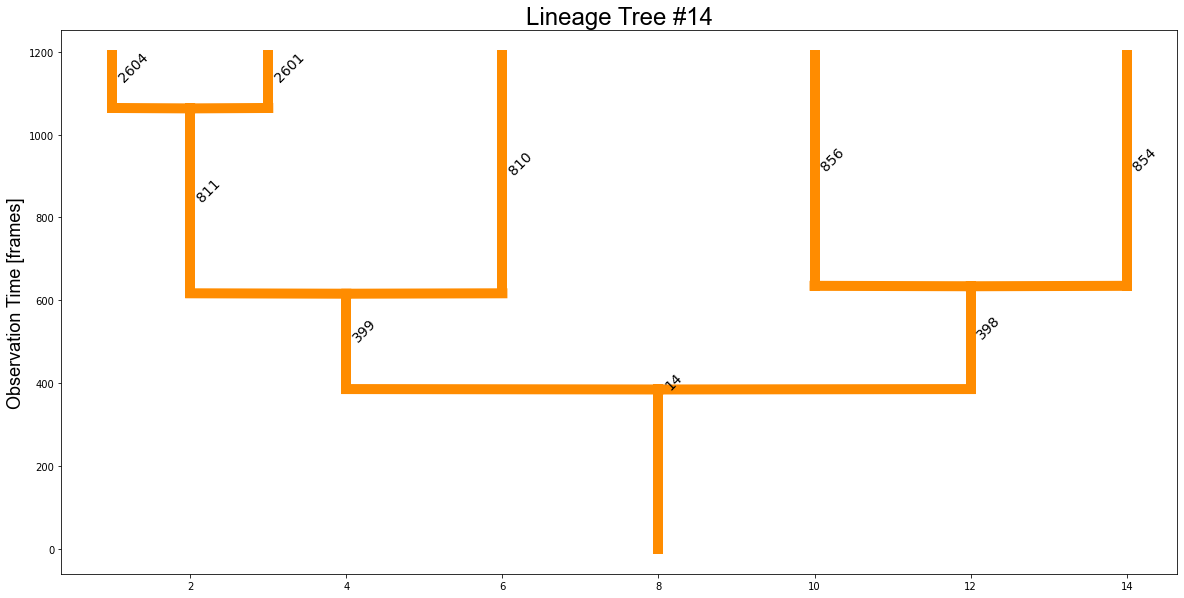

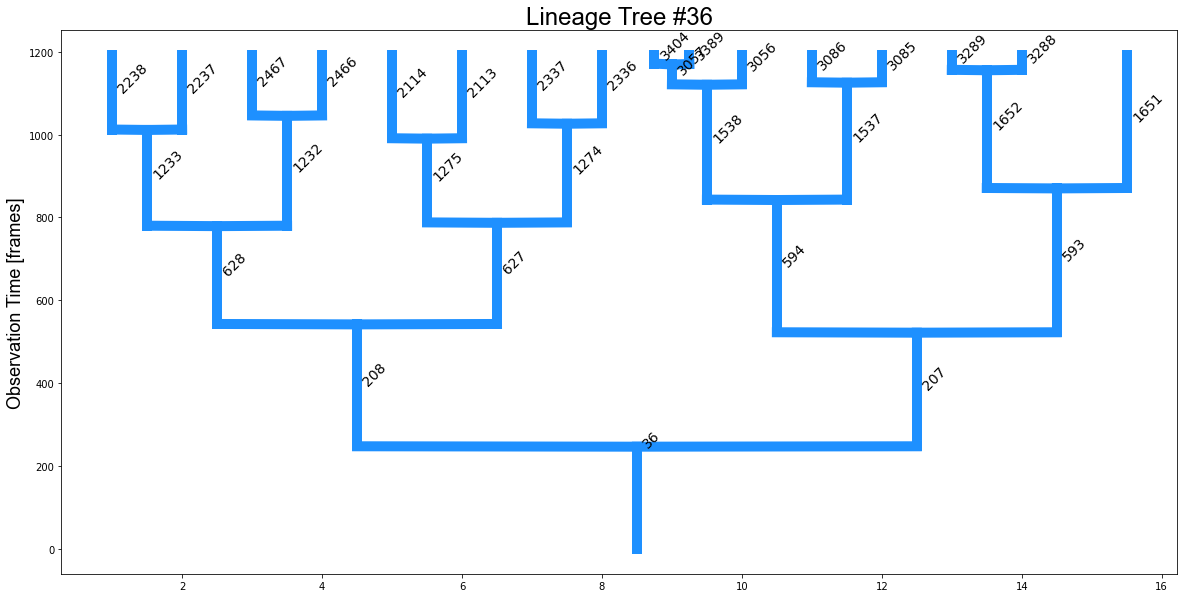

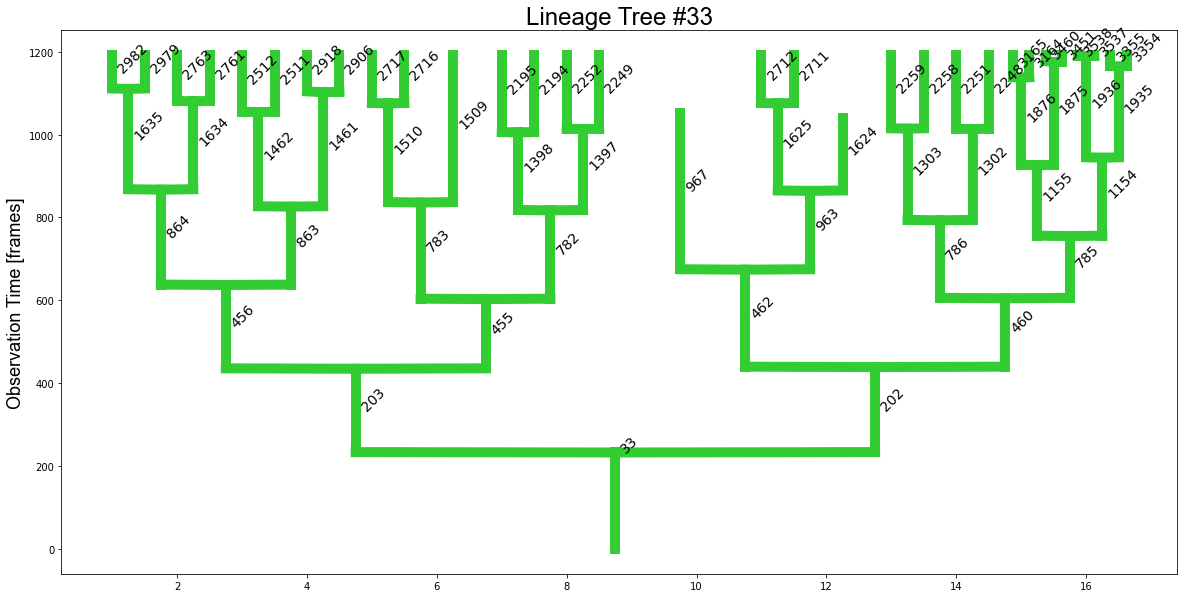

In [14]:
for tree_ID, color in zip(cells, ["darkorange", "dodgerblue", "limegreen"]):
    
    fig, (axs) = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
    
    tree_bt = Lineage_Tree(hdf5_file=hdf5_file, tree_root_ID=tree_ID)
    tree = tree_bt.create_tree()
    LineageTreePlotter_Figure(axis_index=0, order=0).plot(tree=tree, color=color, linewidth=10.0, markersize=0, alpha=1.0, labels=True)
    
    plt.title(f"Lineage Tree #{tree_ID}", fontname="Arial", fontsize=24)
    plt.ylabel("Observation Time [frames]", fontname="Arial", fontsize=18)
    plt.show()
    

### Extract the _(frm, y, x)_ coordinates of all cells which belong to the respective tree into 3 separate arrays to source from later:

In [3]:
cells_data = [[] for _ in range(len(cells))]

with h5py.File(hdf5_file, 'r') as f:
    for enum, c in enumerate(cells):
        for e, cell in enumerate(f["tracks"]["obj_type_1"]["LBEPR"]):
            if cell[0] == c or cell[4] == c:
                cell_map = f["tracks"]["obj_type_1"]["map"][e]
                for trk in f["tracks"]["obj_type_1"]["tracks"][cell_map[0]:cell_map[1]]:
                    #t = f["tracks"]["obj_type_1"]["tracks"][cell_map[0]]
                    coords = f["objects"]["obj_type_1"]["coords"][trk][0:3]
                    cells_data[enum].append(coords)
                    

### Define custom colormap for segmentation masks:

0 - black; 1 - grey; 2 - orange; 3 - blue; 4 - green

In [4]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[0:1, :] = np.array([0/256, 0/256, 0/256, 1])
newcolors[1:2, :] = np.array([150/256, 150/256, 150/256, 1])
newcolors[2:3, :] = np.array([255/256, 140/256, 0/256, 1])
newcolors[3:4, :] = np.array([30/256, 144/256, 255/256, 1])
newcolors[4:5, :] = np.array([50/256, 205/256, 50/256, 1])
newcmp = ListedColormap(newcolors[:5])


### Visualise individual frames with 100-frame increments using the custom colormap:

**Color-coded segmentation mask with a slow (orange), medium (blue) & fast (green) dividing cell on _frames 0 - 800_**

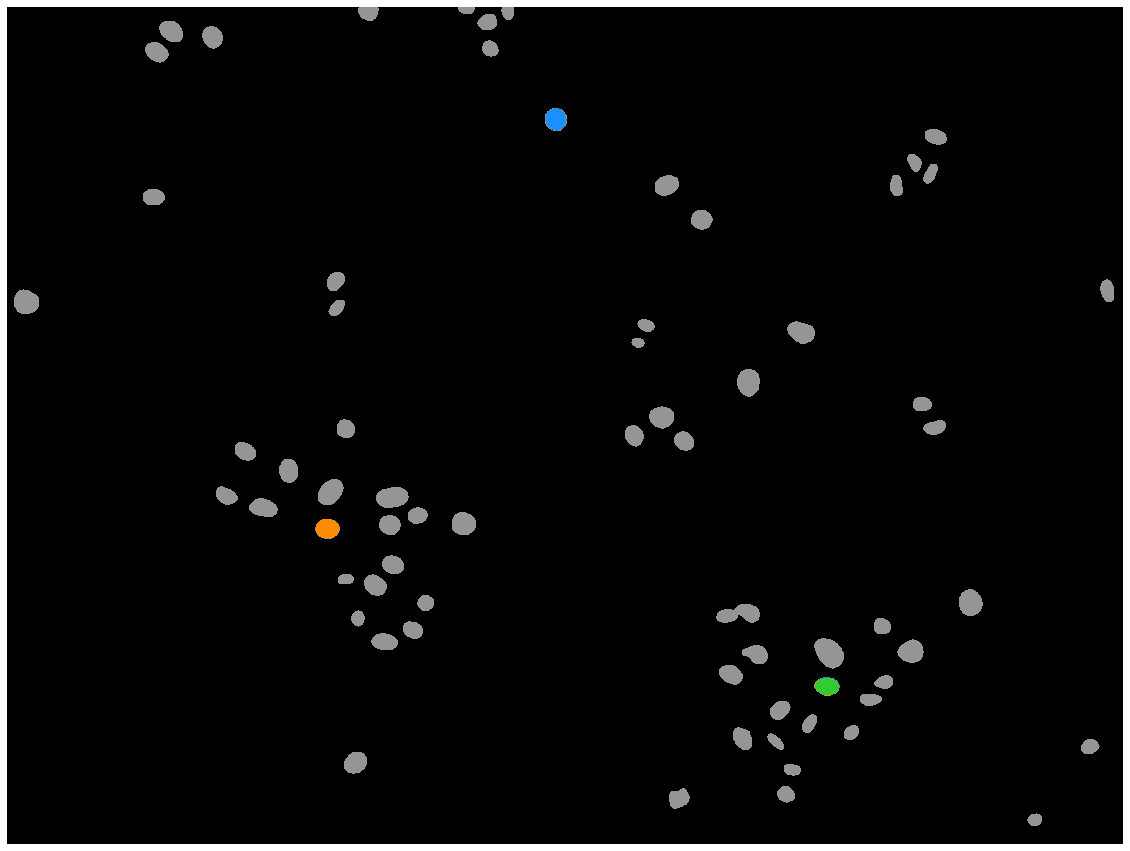

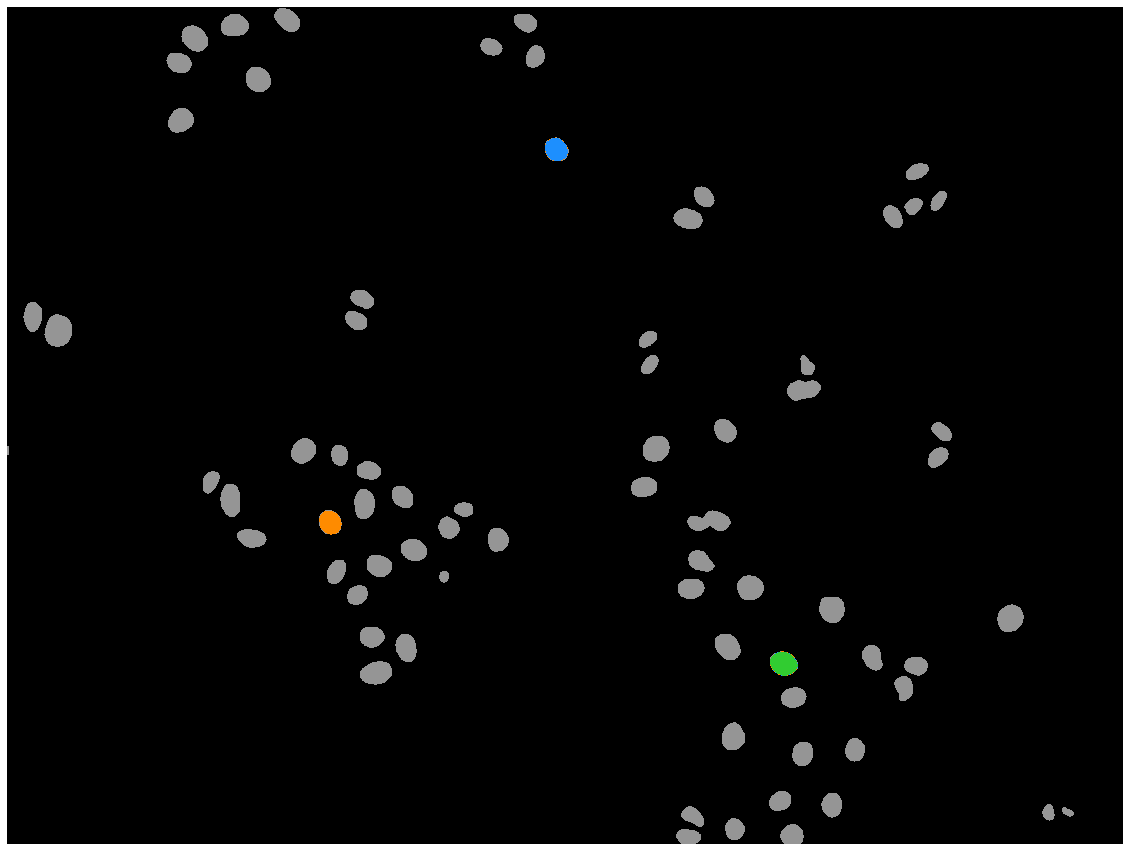

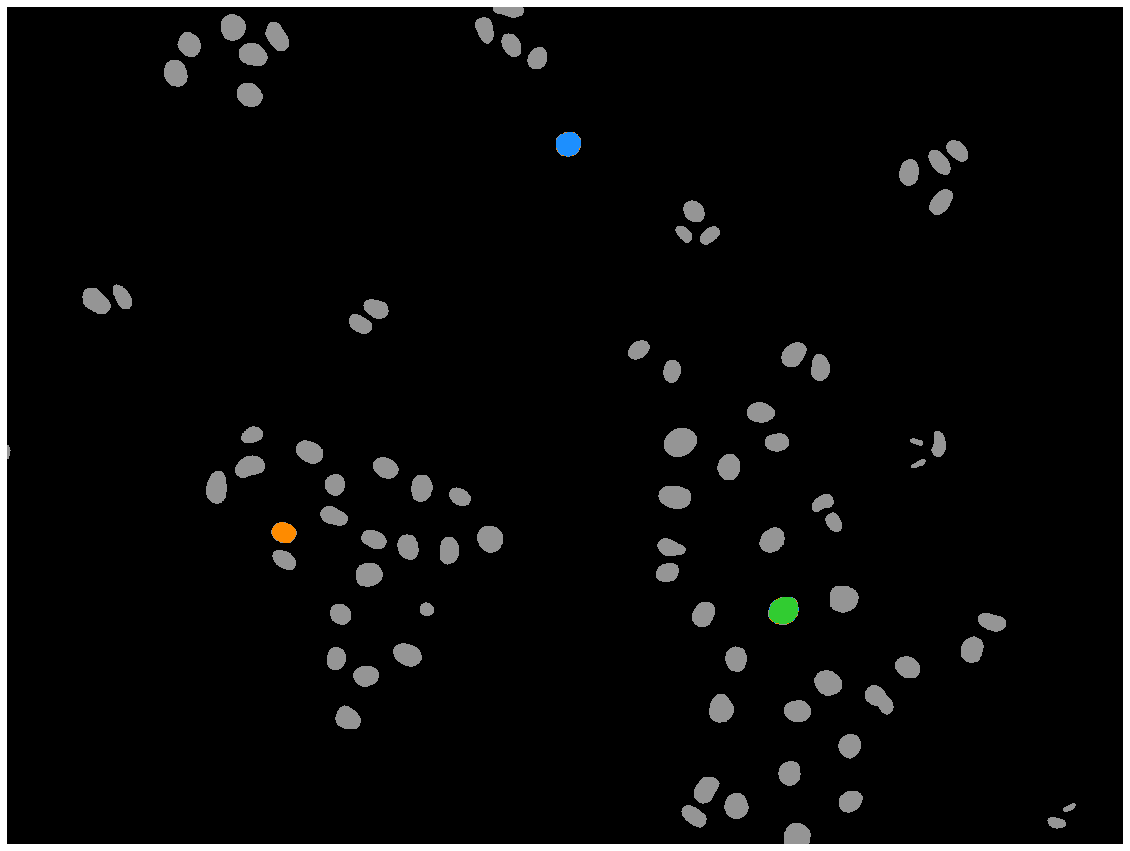

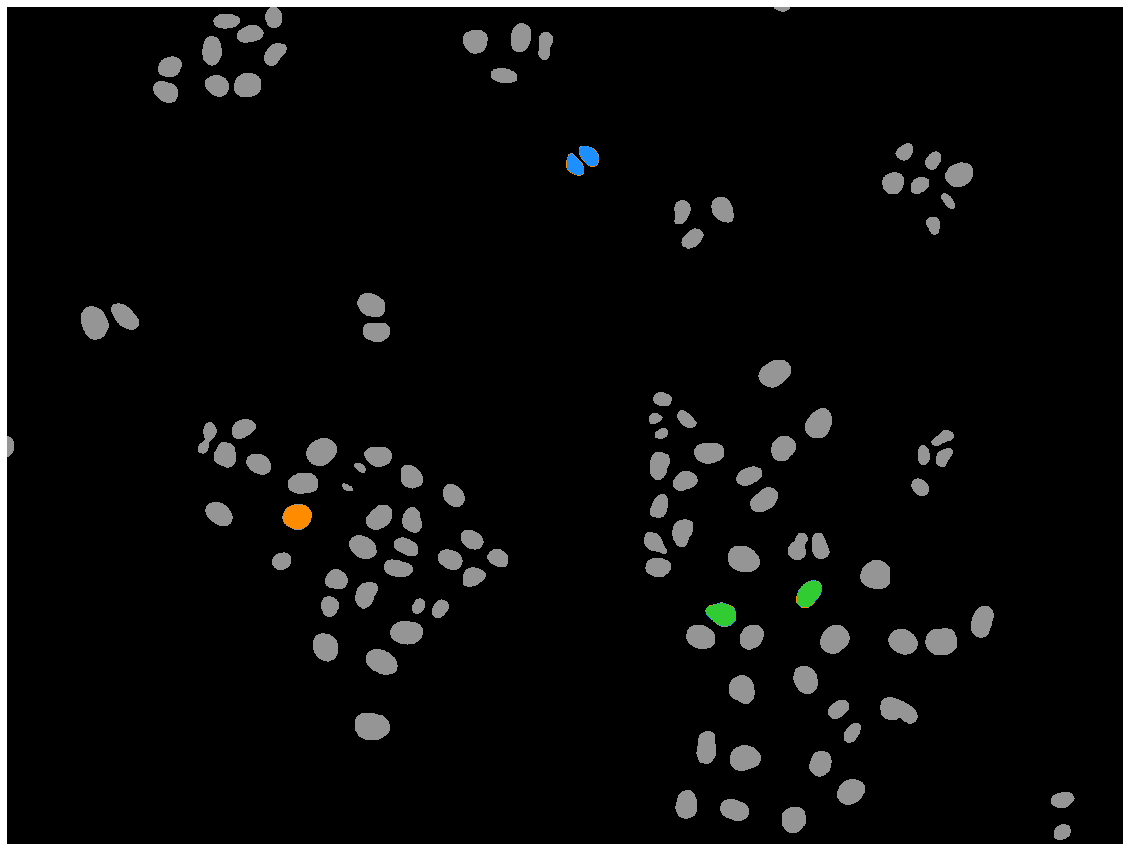

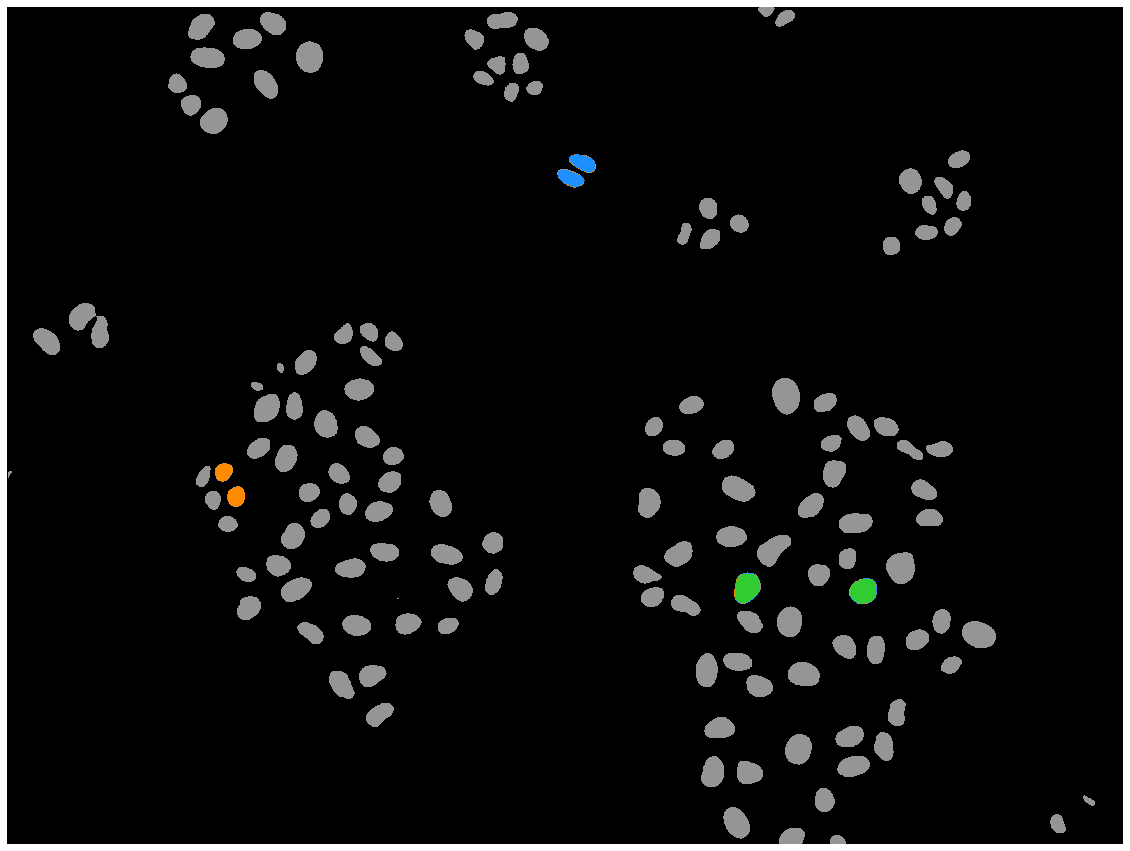

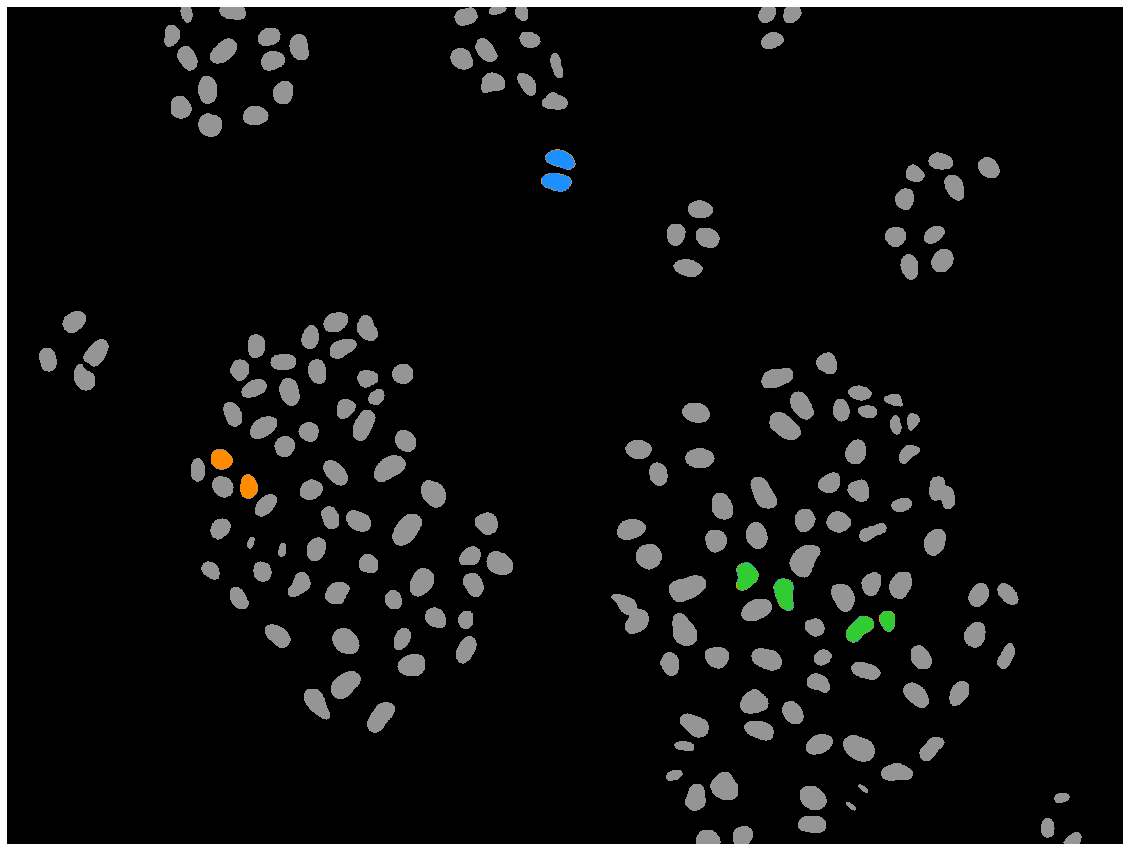

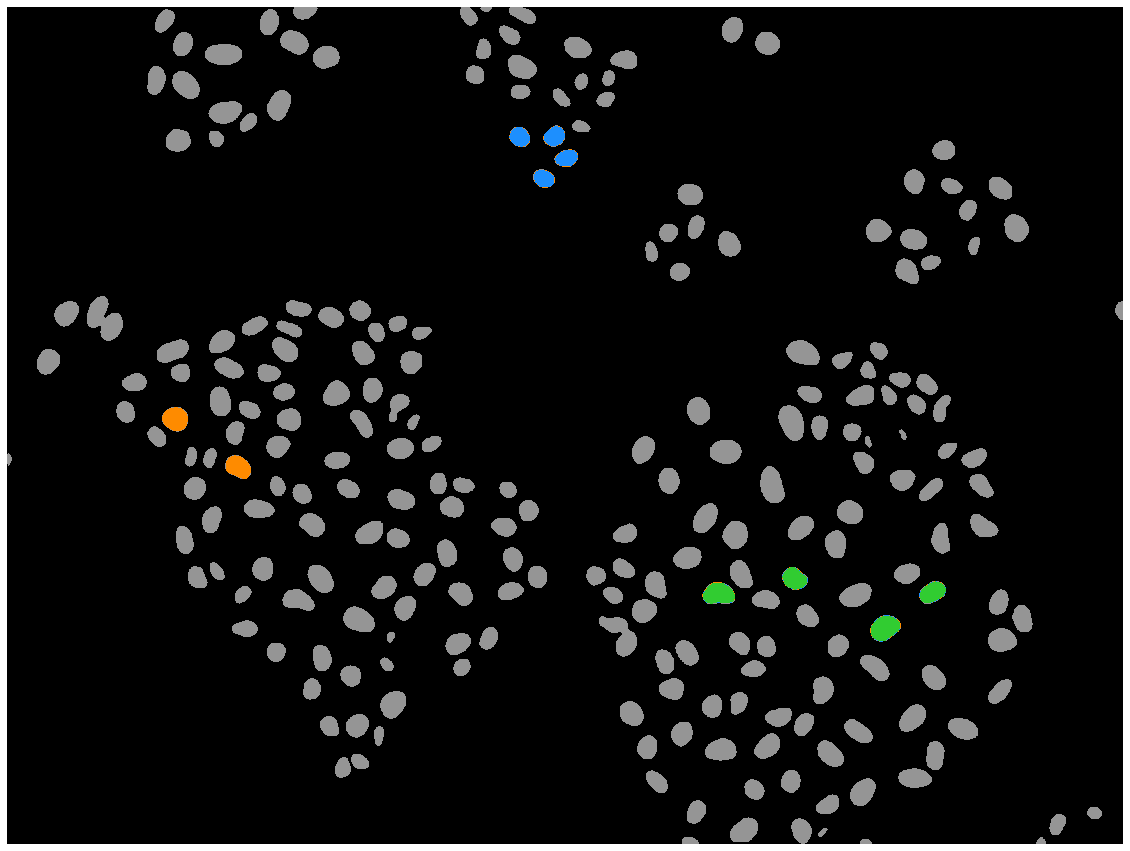

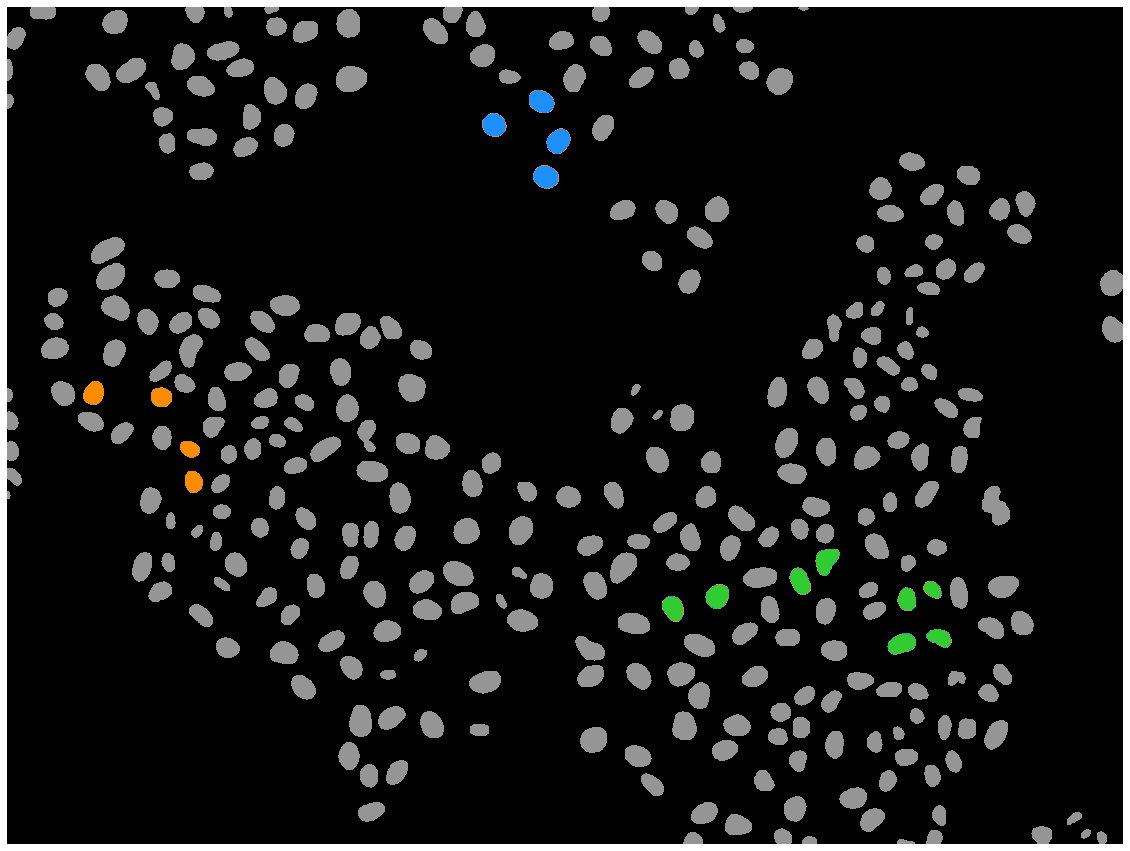

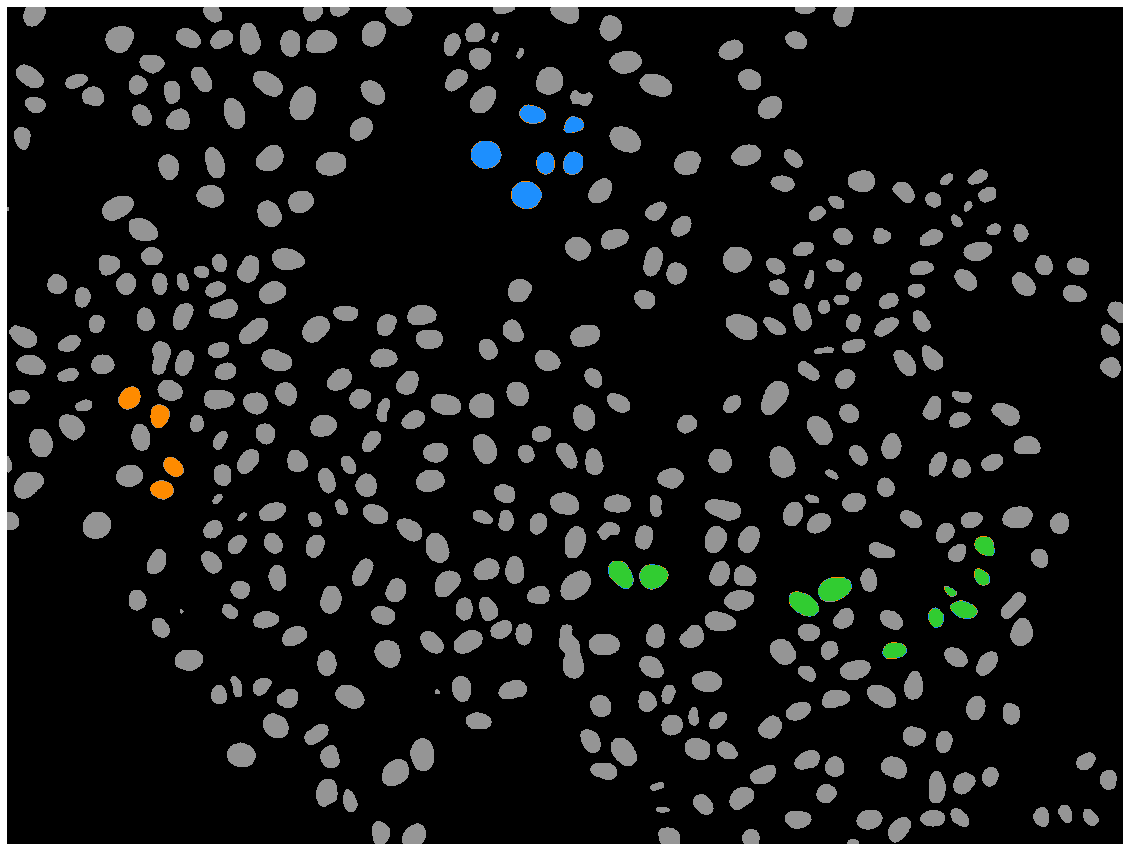

In [5]:
with h5py.File(hdf5_file, 'r') as f:
    
    for frame in range(0, 800 + 1, 100):
        
        # Open the segmentation mask for current frame:
        fig, axs = plt.subplots(figsize=(20, 16))
        img = f["segmentation"]["images"][frame]
        
        # Modify those cells which you shortlisted: 
        for e, cell in enumerate(cells_data):
            for sublist in cell:
                if sublist[0] == frame:
                    flood_fill(image=img, seed_point=(int(sublist[1]), int(sublist[2])), new_value=e+2, in_place=True)
        
        # Visualise:
        plt.axis("off")
        plt.ion()
        plt.imshow(img, cmap=newcmp)
        #plt.show()
        #plt.imsave(fname = f"seg_{frame}.tiff", arr=img, cmap=newcmp)
         

### Plot on individual axes on one figure:

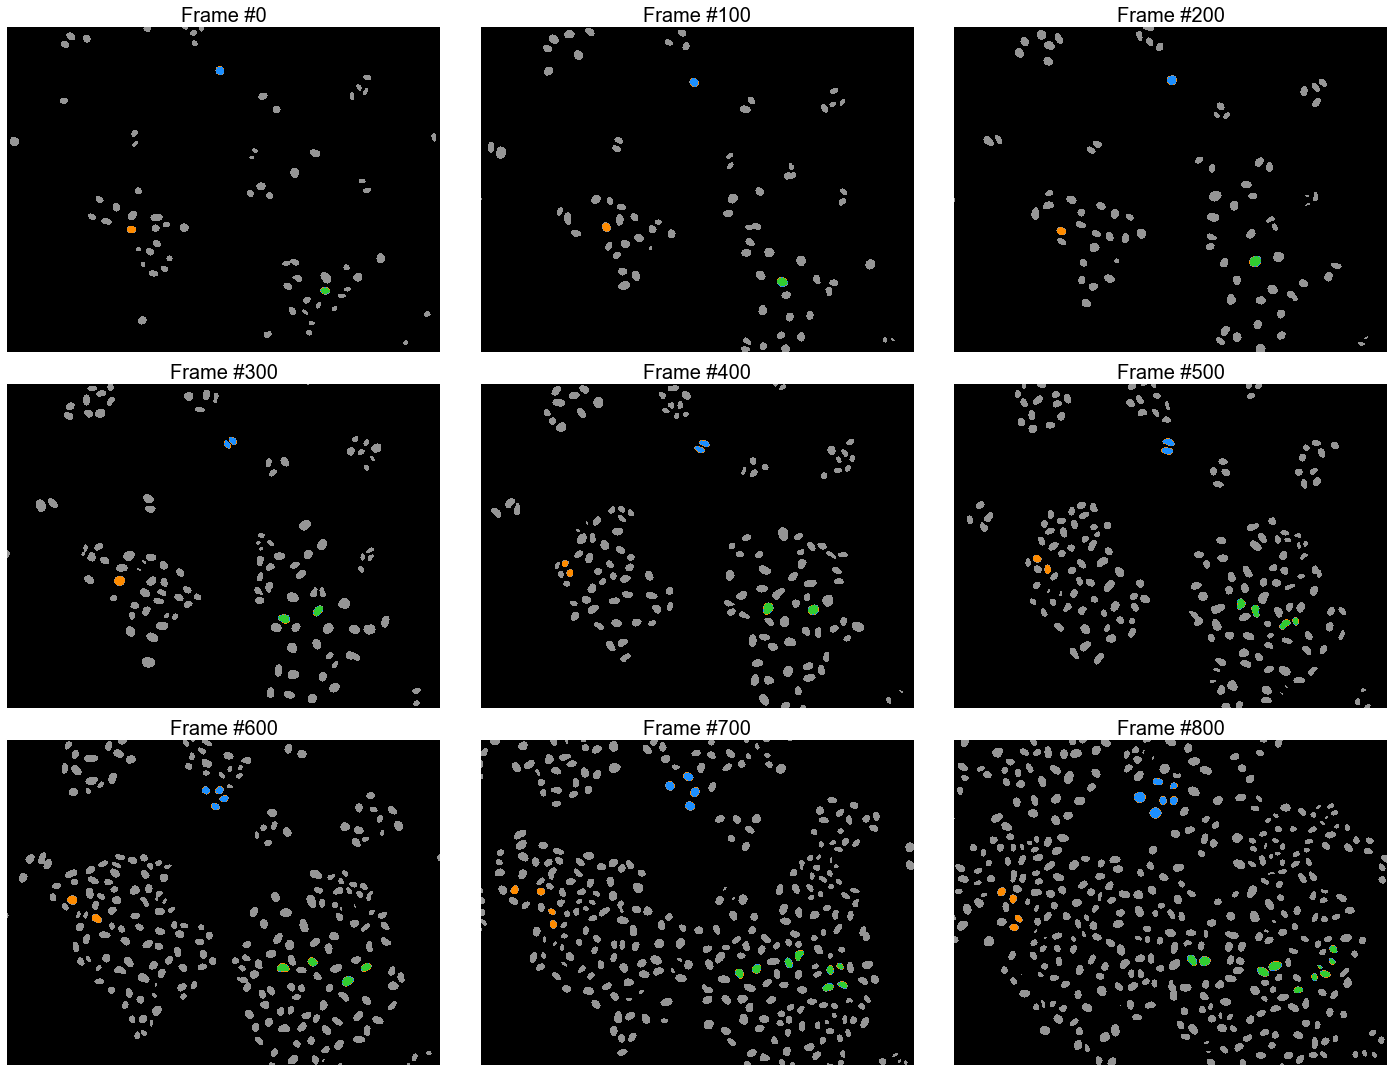

In [6]:
fig, axs = plt.subplots(figsize=(20, 15), nrows=3, ncols=3, sharex=True, sharey=True)


with h5py.File(hdf5_file, 'r') as f:
    
    for eee, frame in enumerate(range(0, 800 + 1, 100)):
        
        # Open the segmentation mask for current frame:
        img = f["segmentation"]["images"][frame]
        
        # Modify those cells which you shortlisted: 
        for e, cell in enumerate(cells_data):
            for sublist in cell:
                if sublist[0] == frame:
                    flood_fill(image=img, seed_point=(int(sublist[1]), int(sublist[2])), new_value=e+2, in_place=True)
        
        # Visualise:
        axs[eee//3, eee%3].set_title(f"Frame #{frame}", fontname="Arial", fontsize=20)
        axs[eee//3, eee%3].axis("off")
        axs[eee//3, eee%3].imshow(img, cmap=newcmp)
         
plt.tight_layout()
plt.show()


### Done!